In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def extract_features(file_path, segment_duration=1, target_sr=48000, visualize=True):
    """Extract audio features with resampling to 48kHz.
    
    Args:
        file_path (str): Path to audio file
        segment_duration (float): Duration of each segment in seconds (default: 1s)
        target_sr (int): Target sample rate (default: 48000)
        visualize (bool): Whether to plot features (default: True)
        
    Returns:
        list: Dictionary of features per segment
    """
    # Load audio with forced resampling
    y, original_sr = librosa.load(file_path, sr=target_sr, res_type='kaiser_best')
    
    # Verify resampling succeeded
    if original_sr != target_sr:
        print(f"Resampled from {original_sr}Hz to {target_sr}Hz")
    
    features_list = []
    segment_length = int(segment_duration * target_sr)
    num_segments = int(np.floor(len(y) / segment_length))
    
    # Initialize feature containers
    times = []
    pitch_means = []
    centroids = []
    rms_energies = []

    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length
        segment = y[start:end]
        
        # Skip empty segments
        if len(segment) < segment_length // 2:
            continue
            
        # 1. Pitch Tracking (PYIN)
        f0, voiced_flag, _ = librosa.pyin(
            segment,
            fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'),
            sr=target_sr,
            frame_length=min(2048, segment_length)
        )
        pitch_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0
        
        # 2. Spectral Centroid
        centroid = librosa.feature.spectral_centroid(
            y=segment, 
            sr=target_sr,
            n_fft=min(2048, segment_length)
        )[0]
        centroid_mean = np.mean(centroid)
        
        # 3. RMS Energy
        rms = librosa.feature.rms(
            y=segment,
            frame_length=segment_length,
            hop_length=segment_length,
            center=False
        )[0]
        rms_mean = np.mean(rms)
        
        # Store features
        mid_time = (start + end) / 2 / target_sr
        times.append(mid_time)
        pitch_means.append(pitch_mean)
        centroids.append(centroid_mean)
        rms_energies.append(rms_mean)
        
        features_list.append({
            'Segment': i,
            'Time (s)': mid_time,
            'Pitch (Hz)': pitch_mean,
            'Centroid (Hz)': centroid_mean,
            'RMS': rms_mean
        })

    if visualize and num_segments > 0:
        _plot_features(times, pitch_means, centroids, rms_energies)
        
    return features_list

def _plot_features(times, pitch, centroid, rms):
    """Internal plotting function"""
    plt.figure(figsize=(14, 8))
    
    # Pitch plot
    ax1 = plt.subplot(311)
    ax1.plot(times, pitch, 'b-o', alpha=0.7)
    ax1.set_ylabel('Pitch (Hz)', color='b')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Centroid plot
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(times, centroid, 'g-s', alpha=0.7)
    ax2.set_ylabel('Centroid (Hz)', color='g')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # RMS plot
    ax3 = plt.subplot(313, sharex=ax1)
    ax3.plot(times, rms, 'r-^', alpha=0.7)
    ax3.set_ylabel('RMS Energy', color='r')
    ax3.set_xlabel('Time (s)')
    ax3.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle('Audio Features (Resampled to 48kHz)')
    plt.tight_layout()
    plt.show()

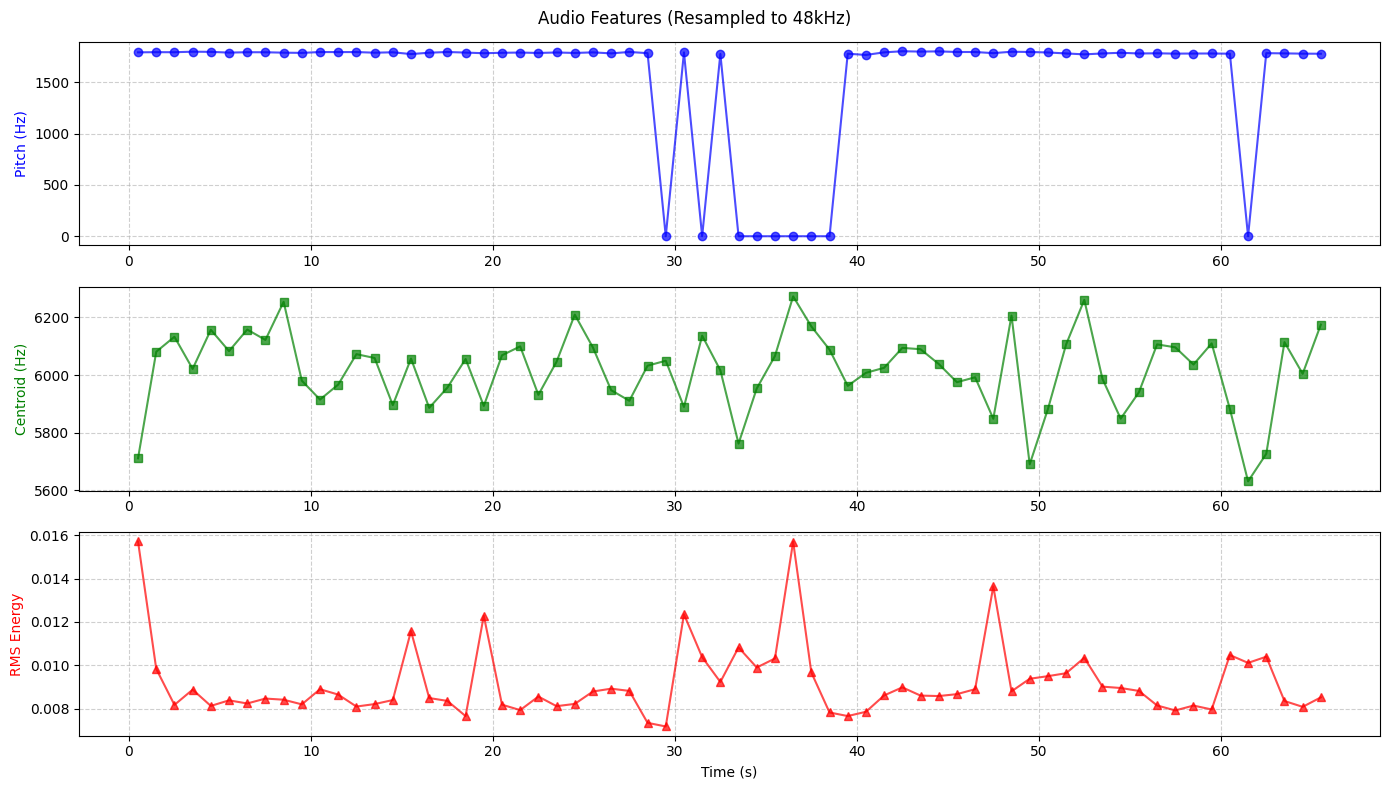

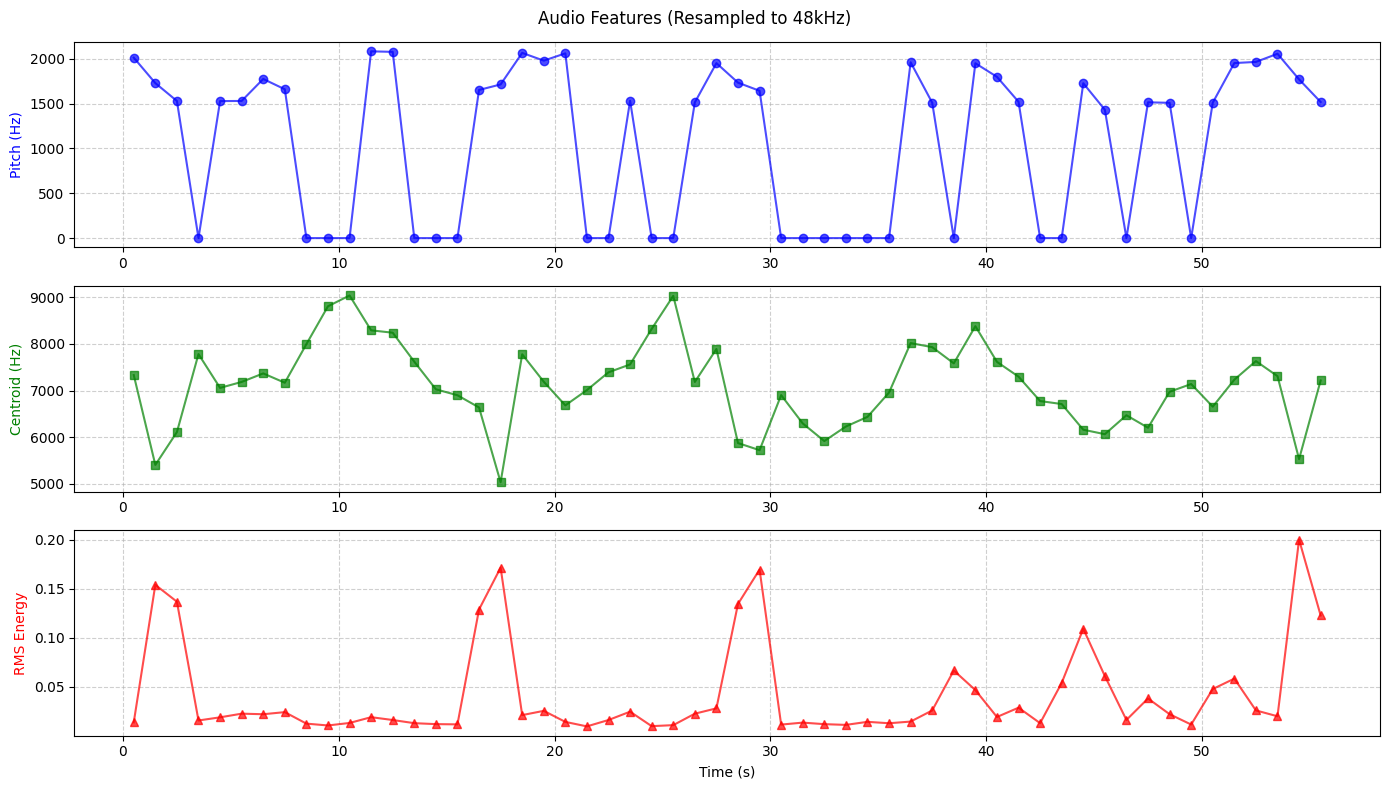

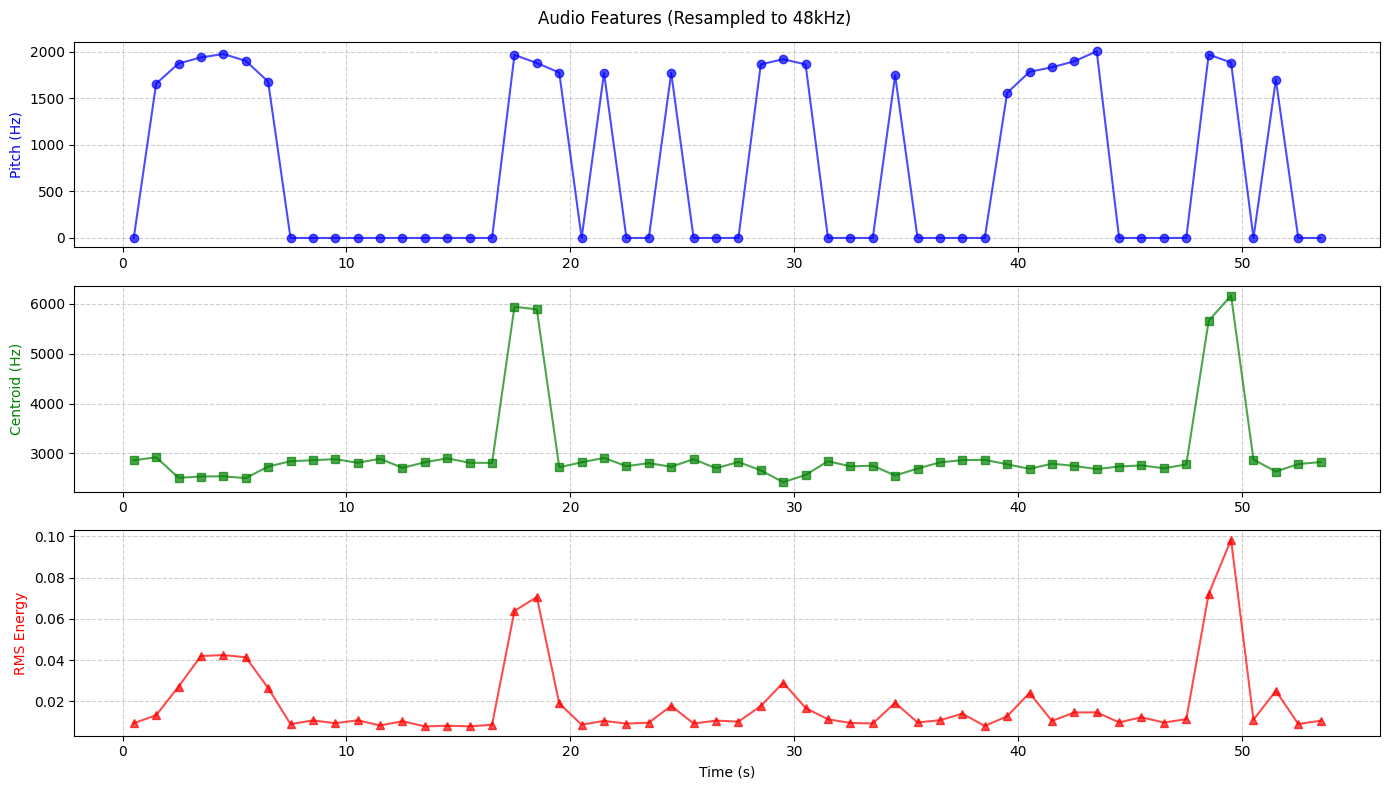

In [10]:
dir_birdsound = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto"

for file_birdsound in os.listdir(dir_birdsound):
    file_path = os.path.join(dir_birdsound, file_birdsound)
    extract_features(file_path)